In [20]:
#setup
data_dir='../../Data/Weather'
file_index='BSSSBSBS'
m='PRCP'

In [35]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [22]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


/home/kf/anaconda3/envs/cse255/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'Circle', 'box', 'interactive', 'Rectangle', 'Polygon', 'load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [6]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,m)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+-------------------+-------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|            coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+---------+------+--------------------+------+
| 466.95723659418354|-1278.9963596923453|-513.1114539356267|     71.9|BSSSBSBS|  30.737|  -88.274|       PRCP| 0.9360290334805637|0.46452491388838835| 0.3906573497342695|0.8533052146016973|US1ALMB0024|4111047.0|    18|[80 4B 00 00 00 0...|2010.0|
| -1572.0685

In [7]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(2779, 365)

In [8]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

In [11]:
np.all(STAT[m]['eigval']>0)

True

## Plotting mean +/-1 std of PRCP

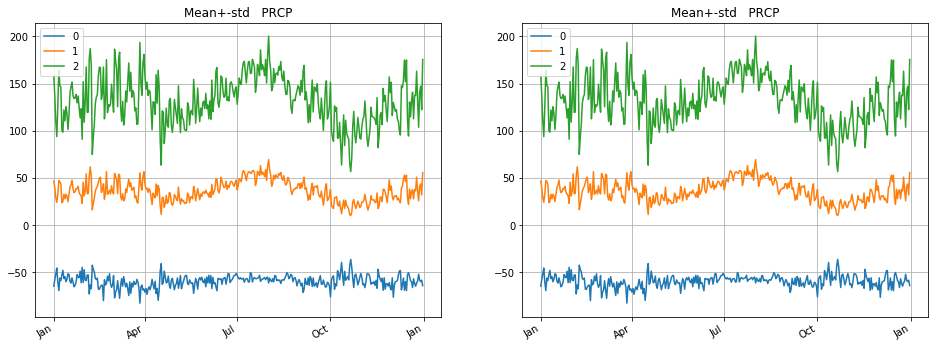

In [102]:
plot_pair([m, m],plot_mean_std)

## Plotting PRCP for a couple of years

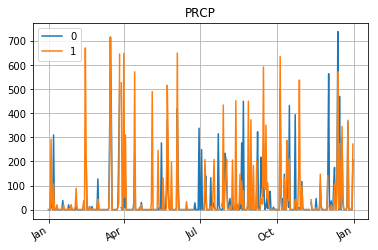

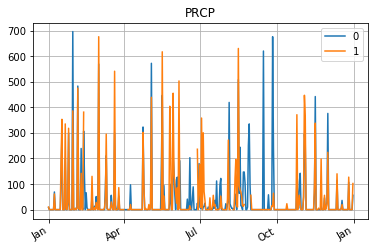

In [13]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)
fig, ax = plt.subplots(figsize=(6,4));
YP.plot(T[20:22].transpose(),fig,ax,title=m)

In [23]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_1|
+-----------+--------+---------+---------+-------------------+
|US1ALMB0024|  30.737|  -88.274|     71.9| 466.95723659418354|
|US1ALBW0004|  30.622| -87.9014|     43.9| -1572.068530635822|
|US1ALMB0010| 30.6309| -88.2739|     54.9| -1349.298205014159|
|US1ALBW0032| 30.5566| -87.9013|      3.4|-1294.9245340205998|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [24]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
101,US1ALBW0001,30.5483,-87.8887,32.9,5,-69.605882
94,US1ALBW0003,30.6424,-87.9076,48.2,5,-149.466411


In [31]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
print _min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

print get_color(_min), get_color(_max)

-1495.30433169 501.802602175
#000080 #800000


In [26]:
min_lat,max_lat,min_long,max_long = box = (pdf['latitude'].min()-1, pdf['latitude'].max()+1, pdf['longitude'].min()-1, pdf['longitude'].max()+1)

In [34]:
?Rectangle

## Plotting data count of stations on a map

In [39]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m_leaflet = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m_leaflet += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
#fill_color=get_color(_coef)
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    #print get_color(_coef)
    circles.append(c)
    m_leaflet.add_layer(c)
m_leaflet

We see that the data comes from the southern part of Alabama and northwest part of Florida. Some stations have much higher number of records than others.

## Top 10 PCA components of PRCP

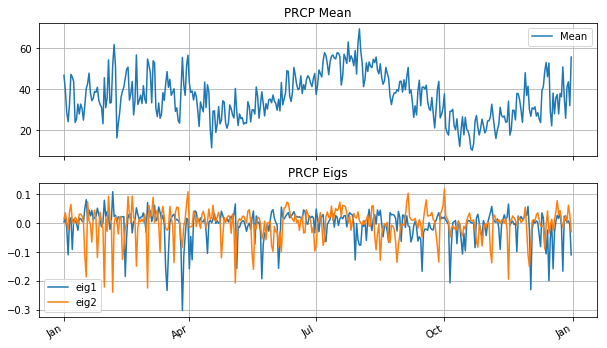

In [41]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=2
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

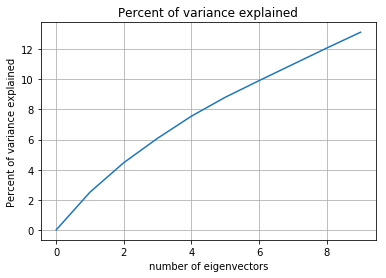

In [8]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval'][:]; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

We see that the top 10 PCA components only explain 13% of the variance. This shows that the data has high variability, and is difficult to summarize in a low number of dimensions.

In [36]:
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[10],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

residual normalized norm  after mean: 0.86444927638
residual normalized norm  after mean + top eigs: [ 0.94567224  0.48996002  0.40393068  0.40394808  0.40366937  0.40329831
  0.39492026  0.39462328  0.38873359  0.38859333]


In [39]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)

In [40]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 2779
after filter 2779


At least all the data is better approximated by the mean than zero, which is not the case for SNWD.

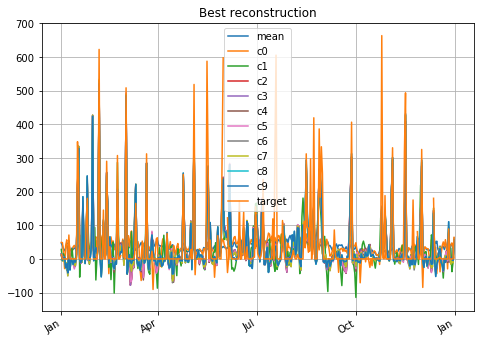

In [41]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

As mentioned above, since the first few PCA components can only explain a low percentage of the variance, we don't expect the reconstruction using the these eigenvectors to come close to the target. This can be seen in the widget above: even with 10 eigenvectors at the optimal coefficients, the reconstruction does not seem close to the target.

In [9]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()

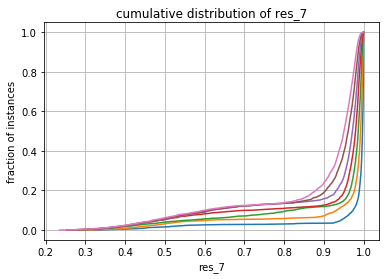

In [64]:
for i in range(1,8):
    plot_CDF(df2,'res_{}'.format(str(i)))

This plots the distribution of the first 7 residuals. The curves shift from the bottom right corner towards the top right corner slowly. We can see that even after incorporating the 7th component, almost 80% of the data still has residual ratio of 0.9 (1 is the highest), so PCA doesn't do a good job explaining the data.

In [43]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [48]:
np.nansum(rows[0][2])

13528.0

In [49]:
All_by_year = {}
years = maxy-miny+1
i=0
for station,year,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All_by_year:
        a=np.zeros(years)
        a.fill(np.nan)
        All_by_year[station]=a
    loc = int(year-miny)
    All_by_year[station][loc]=np.nanmean(vector)

/home/kf/anaconda3/envs/cse255/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [12]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [14]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

US1ALBW0031 1728
US1ALBW0030 1703
US1FLOK0026 317
US1ALBW0032 321
US1FLOK0020 1282
US1FLOK0023 1762
US1ALBW0039 1442
US1ALBW0038 1023
US1FLOK0029 1453
US1ALMB0049 1663
USC00012670 3216
US1ALMB0041 999
US1ALMB0042 338
USC00010402 17194
US1ALMB0044 1035
USC00228382 6855
USC00010407 4293
US1ALMB0047 1433
USW00053843 1337
USW00063870 1038
US1ALMB0017 329
USC00014822 9387
USC00015842 696
USC00086129 3074
USC00014431 11972
US1FLES0013 708
US1ALCF0004 1050
US1FLES0010 1755
US1FLES0017 321
US1FLES0015 1067
US1ALBW0026 1413
US1ALBW0027 1404
USC00081299 1060
USC00016937 15956
USW00093859 5076
USC00011566 20354
USW00013899 23156
USC00010252 25449
USC00012577 25642
US1FLWT0014 344
USC00089206 6357
USC00012172 12780
USC00012675 13231
USC00226054 338
US1FLWT0013 724
USW00093826 1813
US1ALDL0001 1336
US1FLOK0024 1776
US1FLES0002 1776
USW00003855 21536
US1FLWT0005 1662
US1FLES0005 1365
USW00093828 1788
US1FLWT0006 988
USW00093841 19677
USC00012813 26435
USW00063899 1788
USC00226790 680
US1ALBW0053 129

We see that the number of valid data at each station is highly variable.

In [52]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(171, 44895)


In [53]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

/home/kf/anaconda3/envs/cse255/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


total RMS                   =  104.148689838
RMS removing mean-by-station=  97.5359394591
RMS removing mean-by-day   =  73.5492120844


In [55]:
B = []
for station in Stations:
    B.append(All_by_year[station])

year_station_table=np.hstack([B])

mean_by_year=np.nanmean(year_station_table,axis=0)
mean_by_station=np.nanmean(year_station_table,axis=1)
tbl_minus_year = year_station_table-mean_by_year
tbl_minus_station = (year_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(year_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-year   = ',RMS(tbl_minus_year)

total RMS                   =  37.1176231979
RMS removing mean-by-station=  6.50125632227
RMS removing mean-by-year   =  4.63459548574


RMS is lower for removing mean-by-day, which implies that there is more variability across days than across stations.

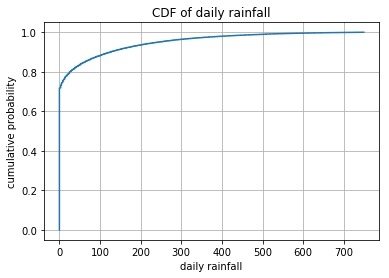

In [17]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]

NN.sort()
P=np.arange(0.,1.,1./len(NN))
plot(NN,P)
grid()
title('CDF of daily rainfall')
xlabel('daily rainfall')
ylabel('cumulative probability')

We see that overall across all stations and years, there is no rainfall for over 70% of the days.

## Log probability of rainfall between pairs of stations

In [57]:
from scipy.special import gammaln,factorial
#for i in range(10):
#    print exp(gammaln(i+1))-factorial(i)
def G(n):
    return gammaln(n+1)
def LogProb(m,l,n1,n2):
    logP=-G(l)-G(n1-l)-G(n2-l)-G(m-n1-n2+l)-G(m)+G(n1)+G(m-n1)+G(n2)+G(m-n2)
    return logP/m
exp(LogProb(1000,0,500,500))

0.501843349103545

In [58]:
def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    G=~isnan(X)
    m=sum(G)
    XG=X[G]>0
    YG=Y[G]>0
    n1=sum(XG)
    n2=sum(YG)
    l=sum(XG*YG)
    logprob=LogProb(m,l,n1,n2)
    # print 'm=%d,l=%d,n1=%d,n2=%d,LogPval=%f'%(m,l,n1,n2,logprob)
    return logprob,m

In [59]:
L=len(Stations)
Pvals=np.zeros([L,L])
Length=np.zeros([L,L])
P_norm=np.zeros([L,L])
for i in range(L):
    print i,
    for j in range(L):
        if i==j: 
            P_norm[i,j]=-0.4
            continue
        X=copy(All[Stations[i]])
        Y=copy(All[Stations[j]])
        P_norm[i,j],Length[i,j]=computeLogProb(X,Y)
        if Length[i,j]<200:
            P_norm[i,j]=np.nan

0 1

/home/kf/anaconda3/envs/cse255/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170


(29241,) (17147,)


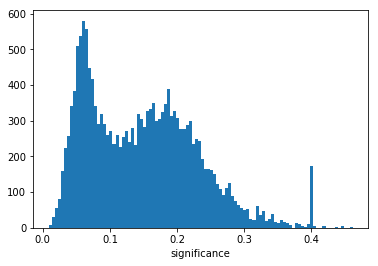

In [70]:
A=P_norm.flatten();
B=A[~isnan(A)]
print A.shape,B.shape
hist(-B,bins=100);
xlabel('significance')

This histogram shows that the occurence of rainfall days between most stations is not highly correlated. 

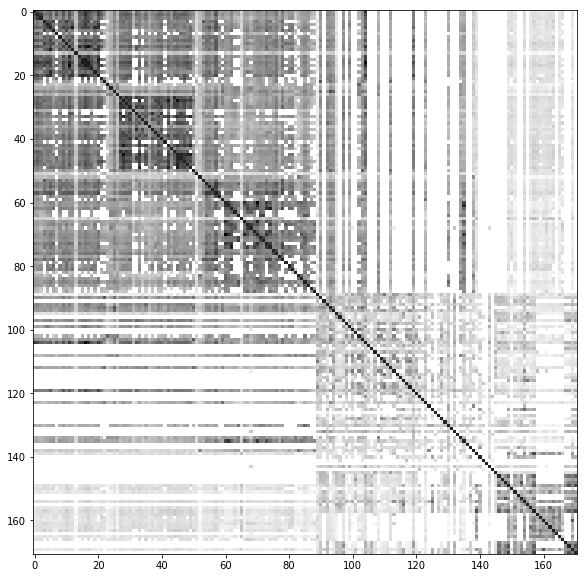

In [60]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.imshow(mat, cmap=plt.cm.gray)
    
showmat(P_norm)

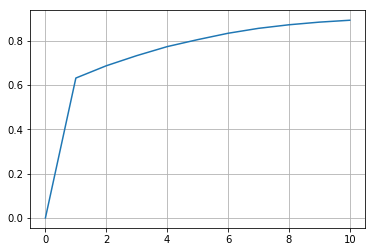

In [72]:
from sklearn.decomposition import PCA
P_norm0 = np.nan_to_num(P_norm)
n_comp=10
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(insert(cumsum(Var_explained),0,0))
grid()

In [73]:
n_comp=4
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [74]:
def re_order_matrix(M,order):
    M_reord=M[order,:]
    M_reord=M_reord[:,order]
    return M_reord

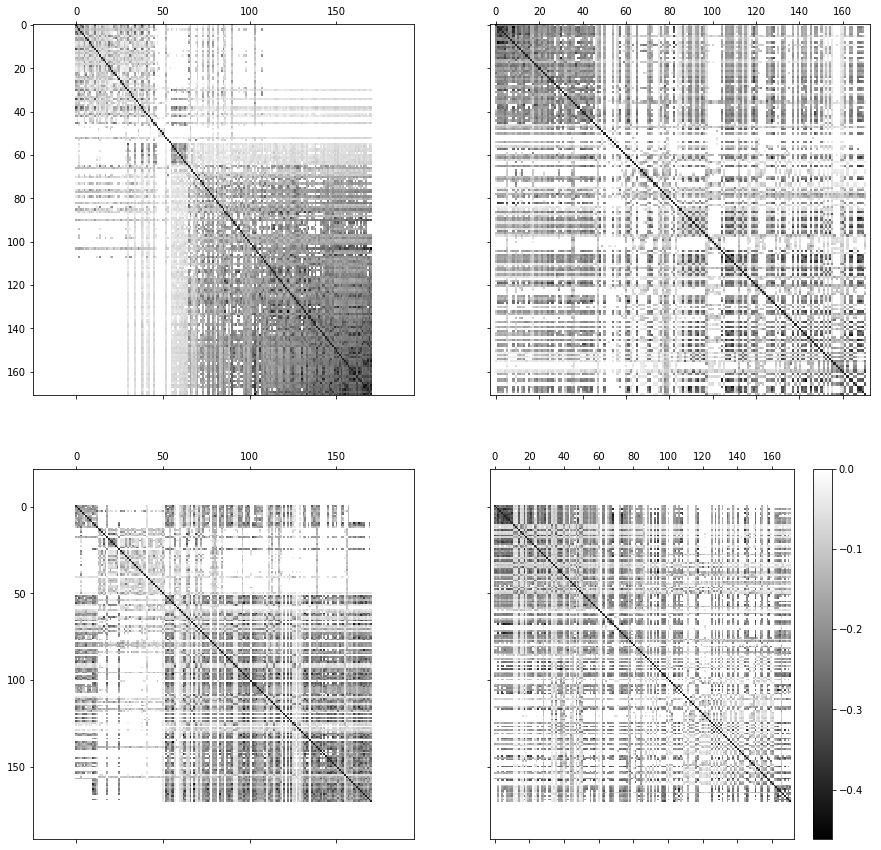

In [83]:
fig,axes=plt.subplots(2,2,figsize=(15,15),sharex='col',sharey='row');
i=0
station_orders = []
for r in range(2):
    for c in range(2):
        order=np.argsort(pca.components_[i,:])
        station_orders.append(order[:20])
        P_norm_reord=re_order_matrix(P_norm0,order)
        heatmap = axes[r,c].matshow(P_norm_reord, cmap=plt.cm.gray)
        i+=1
        
plt.colorbar(heatmap)

## Looking at the strongly correlated block (top left corner) in the first PCA component

In [62]:
coords = []
for o in range(20):
    lats = pdf[pdf['station']==Stations[o]].latitude.values[0]
    longs = pdf[pdf['station']==Stations[o]].longitude.values[0]
    coords.append((lats, longs))

In [63]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m_leaflet = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m_leaflet += r

circles = []
#fill_color=get_color(_coef)
for lats, longs in coords:
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(lats, longs), radius=1000, weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color="#FF0000")
    circles.append(c)
    m_leaflet.add_layer(c)
m_leaflet

I was hoping to see that strongly correlated stations are close together geographically, but plotting them on the map seems to show that that is not the case.